In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
data = pd.read_csv('salary_data.csv')

#### Preprocessing
- Drop na
- Standardize education, gender cols
- Rename cols for easier work

In [79]:
data.rename(columns={
    'Age': 'age',
    'Gender': 'gender',
    'Education Level': 'edu', 
    'Job Title': 'job',
    'Years of Experience':'exp', 
    'Salary': 'salary'}, inplace=True)
data.dropna(inplace=True)
#normalize job titles and education levels
data['gender'] = data['gender'].str.lower().str.strip()
data['job'] = data['job'].str.lower().str.strip()
data['edu'] = data['edu'].str.lower().str.strip()
data['edu'].replace(
    {"bachelor's": "bachelor", 
     "master's": "master", 
     "bachelor's degree": "bachelor",
     "master's degree": "master"}, 
inplace=True)

#### Define Functions

In [80]:
import statsmodels.api as sm 
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
def anova_pairwise_tukeyhsd(df, col1, col2):
    fig = plt.figure(figsize=(4, 2))
    ax1 = fig.add_subplot(1, 1, 1)
    sns.boxplot(x=col1, y=col2, data=df, palette="Set3", ax=ax1)
    plt.show()

    model = ols(f'{col2} ~ C({col1})', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(anova_table)
    print('\n')
    m_comp = pairwise_tukeyhsd(endog=df[col2], groups=df[col1], alpha=0.05)
    print(m_comp)

In [81]:
from scipy.stats import chi2_contingency, chi2
def plot_crosstab_and_show_dependency(df, col1, col2):
    crosstab = pd.crosstab(df[col1], df[col2])
    crosstab.plot(kind='bar', stacked=True, figsize=(5, 3))
    plt.title(f'{col1} vs {col2}')
    plt.show()

    stat, p, dof, expected =chi2_contingency(crosstab)
    print(f'p-value: {p}')
    print(f'dof: {dof}')

    prob = 0.975
    critical = chi2.ppf(prob, dof)
    print(f'probability: {prob}, critical: {critical}, stat: {stat}')

    alpha = 1 - prob
    print(f'alpha (significant): {alpha}, p-value: {p}')
    if p <= alpha:
        print(f'{col1} dependent {col2} (reject H0)')
    else:
        print(f'{col1} independent {col2}(fail to reject H0)')

In [82]:
def num_univariate_analysis(data, col: str):
    #Descriptive statistics
    print(data[col].describe(include='all'))
    col_median = data[col].median()
    col_mode = data[col].mode().iloc[0]
    col_range = data[col].max() - data[col].min()
    col_variance = data[col].var()
    col_skew = data[col].skew()
    col_kurt = data[col].kurt()

    print(f"Median {col_median}")
    print(f"Mode {col_mode}")
    print(f"Range {col_range}")
    print(f"Var {col_variance}")
    print("****************************************************")

    # Histogram
    plt.figure(figsize=(8, 5))
    plt.subplot(1, 3, 1)
    sns.histplot(data[col], kde=True)
    plt.subplot(1, 3, 2)
    plt.hist(data[col])
    plt.subplot(1, 3, 3)
    plt.pie(data[col].value_counts(), labels=data[col].value_counts().index, autopct='%1.1f%%')
    plt.show()
    print(f"Skew {col_skew}")
    print(f"Kurt {col_kurt}")
    if col_skew > 0:
        print("Phân phối lệch phải")
    else:
        print("Phân phối lệch trái")
    
    if col_kurt > 0:
        print("Phân phối nhọn hơn phân phối chuẩn")
    else:
        print("Phân phối có độ nhọn thấp hơn phân phối chuẩn")
    print("****************************************************")

    col_Q1 = data[col].quantile(0.25)
    col_Q3 = data[col].quantile(0.75)
    col_IQR = col_Q3 - col_Q1
    print(f"Q1 - Q3: {col_Q1} - {col_Q3}")
    print(f"IQR {col_IQR}")

    # Boxplot, Outliers
    plt.figure(figsize=(2,2))
    plt.boxplot(data[col])
    plt.show()
    col_outliers_upper_num = data[data[col] > (col_Q3 + 1.5*col_IQR)].shape[0]
    col_outliers_lower_num = data[data[col] < (col_Q1 - 1.5*col_IQR)].shape[0]
    col_outliers_per = (col_outliers_upper_num + col_outliers_lower_num)/data.shape[0] * 100
    print(f"Number of outliers: {col_outliers_upper_num + col_outliers_lower_num}")
    print(f"Number of upper outliers: {col_outliers_upper_num}")
    print(f"Number of lower outliers: {col_outliers_lower_num}")
    print(f"Percentage of outliers: {col_outliers_per}%")
    # vì outlier có tỉ lệ nhỏ (<1%) nên có thể không cần loại bỏ outlier

In [83]:
class PlotType(enumerate):
    HIST = 'hist'
    PIE = 'pie'
    BAR = 'bar'

def cat_univariate_analysis(data:pd.DataFrame, fig_size=(10, 5), exclude_cols=[], num_cols=3, plot_type=PlotType.HIST):
    i = 0
    category_cols = [col for col in data.columns if data[col].dtype == 'object']
    num_rows = len(category_cols) // num_cols + 1
    fig = plt.figure(figsize=fig_size)
    for col in category_cols:
        if col in exclude_cols:
            continue
        i += 1
        fig.add_subplot(num_rows, num_cols, i)
        if plot_type == PlotType.HIST:
            sns.histplot(data[col])
        elif plot_type == PlotType.PIE:
            plt.pie(data[col].value_counts(), labels=data[col].value_counts().index, autopct='%1.1f%%')
        elif plot_type == PlotType.BAR:
            sns.barplot(x=data[col].value_counts().index, y=data[col].value_counts())
        plt.xticks(rotation=90)
        plt.title(col)
    plt.tight_layout()
    plt.show()

In [84]:
numbers_cols = [col for col in data.columns if data[col].dtype != 'object']
description = data.describe()
modes = data.mode().iloc[0] # (1,33)
description.loc['mode'] = modes
description.loc['var'] = data[numbers_cols].var()
standard_error = data[numbers_cols].sem()
description.loc['std'] = standard_error
kurtosis = data[numbers_cols].kurtosis()
description.loc['kur'] = kurtosis
skewness = data[numbers_cols].skew()
description.loc['skew'] = skewness
range = data[numbers_cols].max() - data[numbers_cols].min()
description.loc['range'] = range
description

,age,exp,salary
count,6698.000000,6698.000000,6.698000e+03
mean,33.623022,8.095178,1.153293e+05
std,0.093056,0.074049,6.450262e+02
min,21.000000,0.000000,3.500000e+02
25%,28.000000,3.000000,7.000000e+04
50%,32.000000,7.000000,1.150000e+05
75%,38.000000,12.000000,1.600000e+05
max,62.000000,34.000000,2.500000e+05
mode,27.000000,2.000000,1.400000e+05
var,58.000169,36.727128,2.786762e+09


#### Drill to data jobs only

In [85]:
# get values contain Data
data_jobs = data['job'].value_counts().index
data_keywords = ['data', 'analyst']
data_jobs = [job for job in data_jobs if any(keyword in job for keyword in data_keywords)]

remove_jobs = ['data entry clerk', 'help desk analyst']
data_jobs = [job for job in data_jobs if job not in remove_jobs]

software_jobs = data['job'].value_counts().index
software_keywords = [
    'software', 'engineer', 
    'developer', 'programmer', 
    'mobile', 'full stack', 
    'front end', 'back end', 'web']
remove_jobs = ['software project manager', 'network engineer', 'project engineer', 'junior web designer', 'senior data engineer']
software_jobs = [job for job in software_jobs if any(keyword in job for keyword in software_keywords)]
software_jobs = [job for job in software_jobs if job not in remove_jobs]

data['job_type'] = data['job'].apply(lambda x: 'data' if x in data_jobs else ('software' if x in software_jobs else 'other'))

In [86]:
df_data = data[data['job_type'] == 'data']

def get_level(job):
    if 'junior' in job:
        return 'junior'
    elif 'senior' in job:
        return 'senior'
    elif 'chief' in job or 'director' in job:
        return 'vip'
    else:
        return 'no-level'
df_data['level'] = df_data['job'].apply(lambda x: get_level(x))

C:\Users\PC\AppData\Local\Temp\ipykernel_19556\4269704713.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['level'] = df_data['job'].apply(lambda x: get_level(x))


#### Number Univariate analysis
- Về exp, mức phổ biến là từ 1 - 9 năm, từ 10 exp tỉ lệ giảm, và trên 20 tỉ lệ này còn thấp hơn => phân phối lệch phải mạnh, ngoại lai là > 25.5 và có 75 ngoại lai (làm việc nhiều hơn 25.5 năm). Median là 7, mean là 8 (rất giống khi xét tổng thể nhưng cần t test)
- Về age, phổ biến là khoảng 28 - 36 tuổi, ngoài khoảng này ra thì tỉ lệ các nhóm tuổi còn lại khá thấp, đa phần đều là những người nằm trong độ tuổi vàng lao động (22 - 40), mode(xuất hiện nhiều nhất) là 29, mean là 33, Median là 31 (rất giống khi xét tổng thể nhưng cần t test)
- Range salary phổ biến từ 100000$ - 180000$, mode là 120000$, median và mean là 140000$, 134000$. Phân phối lệch trái mạnh (rất khác so với tổng thể)

count      1198.000000
mean     134059.557596
std       48137.309463
min         350.000000
25%      100000.000000
50%      140000.000000
75%      180000.000000
max      240000.000000
Name: salary, dtype: float64
Median 140000.0
Mode 100000.0
Range 239650.0
Var 2317200562.2936726
****************************************************


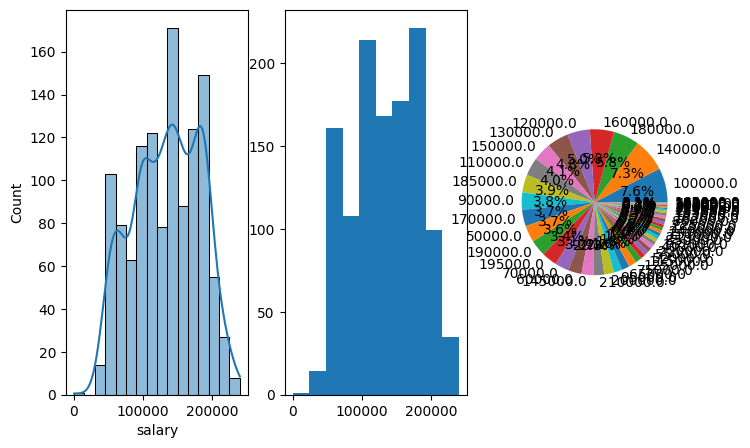

Skew -0.12518421489867498
Kurt -0.9067879812534914
Phân phối lệch trái
Phân phối có độ nhọn thấp hơn phân phối chuẩn
****************************************************
Q1 - Q3: 100000.0 - 180000.0
IQR 80000.0


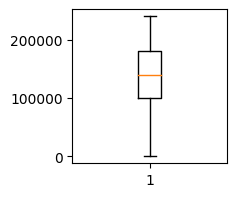

Number of outliers: 0
Number of upper outliers: 0
Number of lower outliers: 0
Percentage of outliers: 0.0%


In [87]:
# num_univariate_analysis(df_data, 'exp')
# num_univariate_analysis(df_data, 'age')
num_univariate_analysis(df_data, 'salary')

#### Category Univariate Analysis
Trong tập dữ liệu:
- Nữ chiếm 37%, nam chiếm 63%
- Bằng cấp 3 chiếm 14.3%. Bằng Cứ nhân chiếm 43%, bằng thạc sĩ chiếm 20%, bằng tiến sĩ chiếm 36% (bằng tiến sĩ cao hơn cả bằng thạc sĩ)
- Xét 100% nhóm các ngành thuộc ngách data
- Ta xem xét thêm yếu tố level trong job title, 83% ko có level, 4.3 là junior, 4.8 là vip, 8.1 là senior

In [88]:
category_cols = [col for col in df_data.columns if df_data[col].dtype == 'object']
for col in category_cols:
    print(f"{col} have {df_data[col].nunique()} unique values: {df_data[col].unique()}")

gender have 2 unique values: ['female' 'male']
edu have 3 unique values: ['master' 'bachelor' 'phd']
job have 25 unique values: ['data analyst' 'marketing analyst' 'financial analyst' 'business analyst'
 'data scientist' 'business intelligence analyst' 'senior data scientist'
 'senior financial analyst' 'operations analyst' 'chief data officer'
 'senior marketing analyst' 'supply chain analyst'
 'senior business analyst' 'junior marketing analyst'
 'junior operations analyst' 'junior data analyst'
 'junior business analyst' 'junior financial analyst'
 'junior data scientist' 'senior operations analyst'
 'senior quality assurance analyst' 'senior data analyst'
 'junior business operations analyst' 'senior data engineer'
 'director of data science']
job_type have 1 unique values: ['data']
level have 4 unique values: ['no-level' 'senior' 'vip' 'junior']


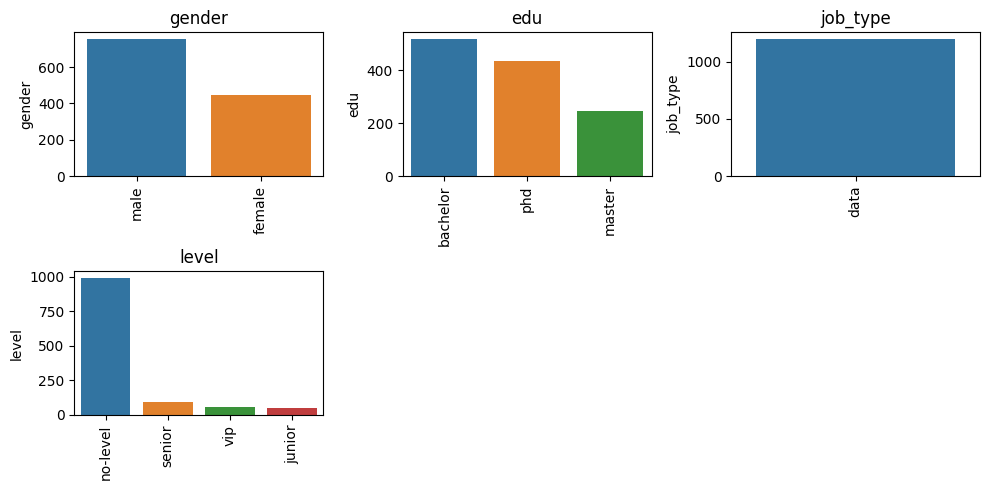

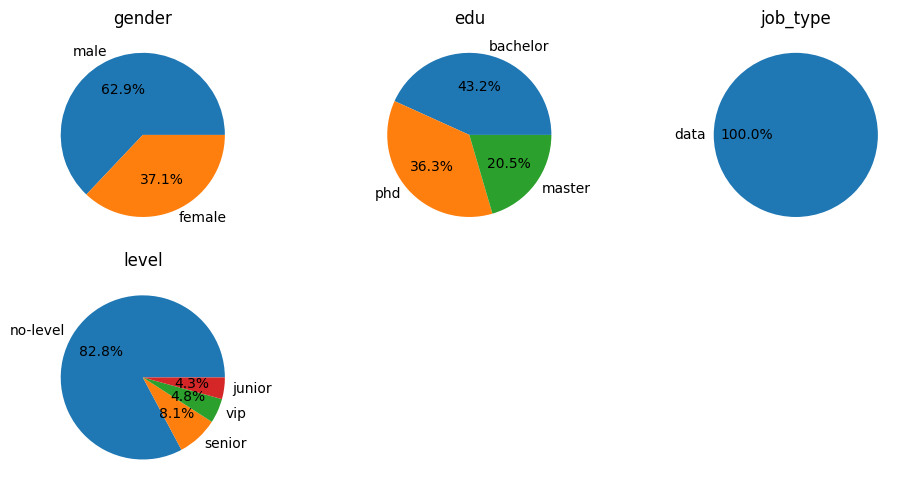

In [89]:
cat_univariate_analysis(df_data, fig_size=(10, 5), exclude_cols=['job'], num_cols=3, plot_type=PlotType.BAR)
cat_univariate_analysis(df_data, fig_size=(10, 5), exclude_cols=['job'], num_cols=3, plot_type=PlotType.PIE)

#### Number vs Number Multivariate Analysis
Dựa vào correlation matrix, Ta thấy exp và age tương quan mạnh, điều này là dễ hiểu, vì càng làm lâu thì tuổi càng lớn, có một số người thì bắt đầu sự nghiệp muộn. Salary tương quan mạnh với exp hơn là với age. Trong nhóm data, ta thấy salary tương quan không mạnh với age và exp như trong tổng thể (có nghĩa ta có thể đạt lương cao với kinh nghiệm thấp hơn và age nhỏ hơn)

Theo T-test hypothesis test

In [90]:
df_data.corr()

C:\Users\PC\AppData\Local\Temp\ipykernel_19556\3492733786.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_data.corr()


,age,exp,salary
age,1.000000,0.972921,0.614898
exp,0.972921,1.000000,0.733098
salary,0.614898,0.733098,1.000000


In [103]:
df_data_junior = df_data[df_data['level'] == 'junior']
df_data_senior = df_data[df_data['level'] == 'senior']
df_data_vip = df_data[df_data['level'] == 'vip']
df_data_no_level = df_data[df_data['level'] == 'no-level']
from scipy.stats import ttest_ind
print(f'junior data salary: {df_data_junior["salary"].mean()} vs no level data salary: {df_data_no_level["salary"].mean()}')
print(ttest_ind(df_data_junior['salary'], df_data_no_level['salary']))
# đây là phép so sánh không tốt vì có quá nhiều dữ liệu, quá nhiều ngành không có level, 
# khiến lương của những người ko có level trở nên quá cao
print('****************************************************')
print('****************************************************')
print(f'junior data salary: {df_data_junior["salary"].mean()} vs senior data salary: {df_data_senior["salary"].mean()}')
print(ttest_ind(df_data_junior['salary'], df_data_senior['salary']))
print(f'junior data age: {df_data_junior["age"].mean()} vs senior data age: {df_data_senior["age"].mean()}')
print(ttest_ind(df_data_junior['age'], df_data_senior['age']))
print(f'junior data exp: {df_data_junior["exp"].mean()} vs senior data exp: {df_data_senior["exp"].mean()}')
print(ttest_ind(df_data_junior['exp'], df_data_senior['exp']))
print('****************************************************')
print('****************************************************')
print(f'senior data salary: {df_data_senior["salary"].mean()} vs vip data salary: {df_data_vip["salary"].mean()}')
print(ttest_ind(df_data_senior['salary'], df_data_vip['salary']))
print(f'senior data age: {df_data_senior["age"].mean()} vs vip data age: {df_data_vip["age"].mean()}')
print(ttest_ind(df_data_senior['age'], df_data_vip['age']))
print(f'senior data exp: {df_data_senior["exp"].mean()} vs vip data exp: {df_data_vip["exp"].mean()}')
print(ttest_ind(df_data_senior['exp'], df_data_vip['exp']))

junior data salary: 49693.13725490196 vs no level data salary: 133930.4435483871
Ttest_indResult(statistic=-13.31859628336313, pvalue=1.743341451269295e-37)
****************************************************
****************************************************
junior data salary: 49693.13725490196 vs senior data salary: 137422.68041237115
Ttest_indResult(statistic=-19.35002989529877, pvalue=3.918097427829685e-42)
junior data age: 29.19607843137255 vs senior data age: 37.25773195876289
Ttest_indResult(statistic=-12.376361265959194, pvalue=1.6478551343783829e-24)
junior data exp: 2.8627450980392157 vs senior data exp: 11.278350515463918
Ttest_indResult(statistic=-17.253664055097484, pvalue=4.626706605556831e-37)
****************************************************
****************************************************
senior data salary: 137422.68041237115 vs vip data salary: 204827.58620689655
Ttest_indResult(statistic=-15.952040191678757, pvalue=2.3239191447695092e-34)
senior data age:

In [105]:
df_data_analyst_junior = df_data_junior[df_data_junior['job'].str.contains('data analyst')]
df_data_analyst_senior = df_data_senior[df_data_senior['job'].str.contains('data analyst')]
df_data_analyst_no_level = df_data_no_level[df_data_no_level['job'].str.contains('data analyst')]

print(f'junior data analyst salary: {df_data_analyst_junior["salary"].mean()} vs senior data analyst salary: {df_data_analyst_senior["salary"].mean()}')
print(ttest_ind(df_data_analyst_junior['salary'], df_data_analyst_senior['salary']))
print('****************************************************')
print('****************************************************')
print(f'junior data analyst salary: {df_data_analyst_junior["salary"].mean()} vs no level data analyst salary: {df_data_analyst_no_level["salary"].mean()}')
print(ttest_ind(df_data_analyst_junior['salary'], df_data_analyst_no_level['salary']))

junior data analyst salary: 51360.0 vs senior data analyst salary: 155000.0
Ttest_indResult(statistic=-70.20807013214433, pvalue=3.54999567781004e-31)
****************************************************
****************************************************
junior data analyst salary: 51360.0 vs no level data analyst salary: 125090.90909090909
Ttest_indResult(statistic=-11.66869532899743, pvalue=3.737921850292119e-27)


No level **giống mid giữa senior và junior hơn là tương đương với junior**

In [108]:
df_junior_data_analyst = df_data_analyst_junior
# job not contain the word 'data'
df_junior_businesses_analyst = df_data_junior[~df_data_junior['job'].str.contains('data')] #~: not
print(f'junior data analyst salary: {df_junior_data_analyst["salary"].mean()} vs junior businesses analyst salary: {df_junior_businesses_analyst["salary"].mean()}')
print(ttest_ind(df_junior_data_analyst['salary'], df_junior_businesses_analyst['salary']))
print('****************************************************')
print(f'junior data analyst age: {df_junior_data_analyst["age"].mean()} vs junior businesses analyst age: {df_junior_businesses_analyst["age"].mean()}')
print(ttest_ind(df_junior_data_analyst['age'], df_junior_businesses_analyst['age']))
print('****************************************************')
print(f'junior data analyst exp: {df_junior_data_analyst["exp"].mean()} vs junior businesses analyst exp: {df_junior_businesses_analyst["exp"].mean()}')
print(ttest_ind(df_junior_data_analyst['exp'], df_junior_businesses_analyst['exp']))

junior data analyst salary: 51360.0 vs junior businesses analyst salary: 48214.0
Ttest_indResult(statistic=1.0426847583961267, pvalue=0.3023175454978461)
****************************************************
junior data analyst age: 27.84 vs junior businesses analyst age: 30.68
Ttest_indResult(statistic=-4.520673233765794, pvalue=4.0354147188398046e-05)
****************************************************
junior data analyst exp: 2.68 vs junior businesses analyst exp: 3.1
Ttest_indResult(statistic=-1.1844700279381384, pvalue=0.24205902641564978)


Không có sự khác biệt về lương giữa vị trí junior của các title data analyst và các domain business analyst khác, nhưng tuổi của các domain business analyst thì cao hơn khoảng 2 năm, kinh nghiệm thì không quá chênh lệch

In [109]:
df_no_level_data_analyst = df_data_analyst_no_level
# job not contain the word 'data'
df_no_level_businesses_analyst = df_data_no_level[~df_data_no_level['job'].str.contains('data')] #~: not
print(f'no_level data analyst salary: {df_no_level_data_analyst["salary"].mean()} vs no_level businesses analyst salary: {df_no_level_businesses_analyst["salary"].mean()}')
print(ttest_ind(df_no_level_data_analyst['salary'], df_no_level_businesses_analyst['salary']))
print('****************************************************')
print(f'no_level data analyst age: {df_no_level_data_analyst["age"].mean()} vs no_level businesses analyst age: {df_no_level_businesses_analyst["age"].mean()}')
print(ttest_ind(df_no_level_data_analyst['age'], df_no_level_businesses_analyst['age']))
print('****************************************************')
print(f'no_level data analyst exp: {df_no_level_data_analyst["exp"].mean()} vs no_level businesses analyst exp: {df_no_level_businesses_analyst["exp"].mean()}')
print(ttest_ind(df_junior_data_analyst['exp'], df_junior_businesses_analyst['exp']))

no_level data analyst salary: 125090.90909090909 vs no_level businesses analyst salary: 69346.59090909091
Ttest_indResult(statistic=21.63131162815928, pvalue=4.249529076205513e-75)
****************************************************
no_level data analyst age: 28.68595041322314 vs no_level businesses analyst age: 28.505681818181817
Ttest_indResult(statistic=0.499988097735651, pvalue=0.6172882732416869)
****************************************************
no_level data analyst exp: 4.96969696969697 vs no_level businesses analyst exp: 3.710227272727273
Ttest_indResult(statistic=-1.1844700279381384, pvalue=0.24205902641564978)


Khi lên mức mid, lương của nhóm data analyst và business analyst là có chênh lệch , data analyst gấp đôi so với business analyst

#### Category vs Category Multivariate Analysis
Dựa vào chi2 dependency hypothesis testing, ta kết luận
- Trình độ học vấn có phụ thuộc vào gender, hãy xem xét kĩ hơn với phân tích anova
- Qua quan sát ta thấy, muốn càng lên level cao, tỉ lệ bằng cao cũng nhiều hơn

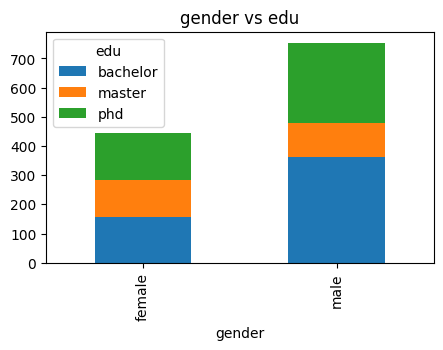

p-value: 6.590877644666749e-08
dof: 2
probability: 0.975, critical: 7.377758908227871, stat: 33.069988452111
alpha (significant): 0.025000000000000022, p-value: 6.590877644666749e-08
gender dependent edu (reject H0)


In [91]:
plot_crosstab_and_show_dependency(df_data, 'gender', 'edu')

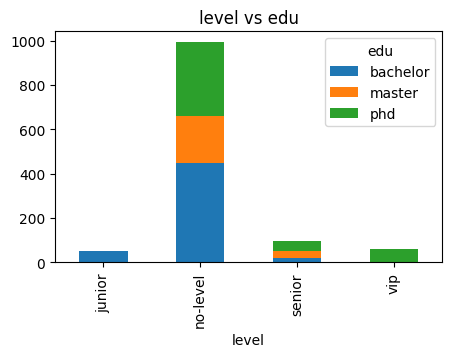

p-value: 1.6016955188684235e-38
dof: 6
probability: 0.975, critical: 14.44937533544792, stat: 190.9453002517942
alpha (significant): 0.025000000000000022, p-value: 1.6016955188684235e-38
level dependent edu (reject H0)


In [110]:
plot_crosstab_and_show_dependency(df_data, 'level', 'edu')

#### Category vs Number Multivariate Analysis
- Trình độ giáo dục càng cao thì mức lương, tuổi cũng càng lớn (xem cụ thể trong anova table), mỗi cấp giáo dục mức lương chênh từ 31000$ - 37000$, mỗi cấp tuổi tăng 3.3 với bachelor lên master, tăng 7y master lên phd, mỗi cấp exp tăng 3 với bachelor lên master và 6y master lên phd
- Lương của nam giới thấp hơn lương của nữ khoảng 1300$ ở các nhóm ngành data nhưng không đủ tin cậy. Nhưng tuổi của nam cũng cao hơn khoảng 3.2
- Kinh nghiệm của **nam giới cao hơn nữ 2y**, ....
- Trình độ học vấn của nam thấp hơn nữ 0.12, 

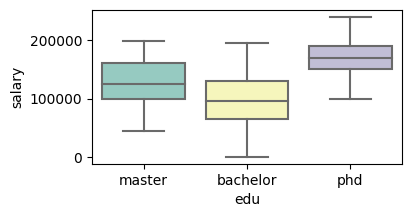

                sum_sq      df           F         PR(>F)
C(edu)    1.129756e+12     2.0  410.618564  1.835324e-136
Residual  1.643933e+12  1195.0         NaN            NaN


     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
 group1  group2  meandiff  p-adj   lower      upper    reject
-------------------------------------------------------------
bachelor master 31425.6895   0.0 24677.0371 38174.3418   True
bachelor    phd 69123.9771   0.0 63463.6744 74784.2797   True
  master    phd 37698.2876   0.0 30745.9717 44650.6035   True
-------------------------------------------------------------


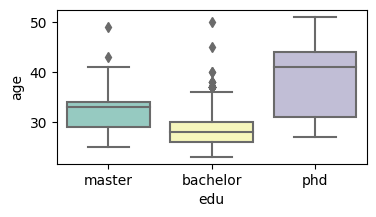

                sum_sq      df           F         PR(>F)
C(edu)    27148.051543     2.0  512.236809  2.202704e-161
Residual  31666.917572  1195.0         NaN            NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj lower   upper  reject
----------------------------------------------------
bachelor master   3.3445   0.0 2.4079  4.2812   True
bachelor    phd  10.6277   0.0 9.8421 11.4133   True
  master    phd   7.2832   0.0 6.3183  8.2481   True
----------------------------------------------------


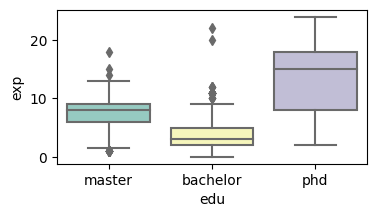

                sum_sq      df           F         PR(>F)
C(edu)    19846.452372     2.0  642.149669  4.128260e-190
Residual  18466.497545  1195.0         NaN            NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05
 group1  group2 meandiff p-adj lower  upper  reject
---------------------------------------------------
bachelor master     2.94   0.0 2.2247 3.6552   True
bachelor    phd   9.0955   0.0 8.4955 9.6954   True
  master    phd   6.1555   0.0 5.4186 6.8924   True
---------------------------------------------------


In [92]:
anova_pairwise_tukeyhsd(df_data, 'edu', 'salary')
anova_pairwise_tukeyhsd(df_data, 'edu', 'age')
anova_pairwise_tukeyhsd(df_data, 'edu', 'exp')

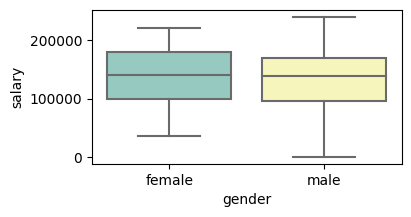

                 sum_sq      df         F    PR(>F)
C(gender)  4.887244e+08     1.0  0.210773  0.646246
Residual   2.773200e+12  1196.0       NaN       NaN


   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2  meandiff  p-adj    lower     upper   reject
----------------------------------------------------------
female   male -1322.4622 0.6462 -6973.967 4329.0426  False
----------------------------------------------------------


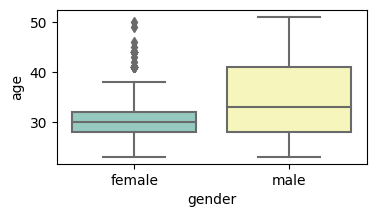

                 sum_sq      df          F        PR(>F)
C(gender)   2921.167152     1.0  62.506321  5.997710e-15
Residual   55893.801963  1196.0        NaN           NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
female   male   3.2332   0.0 2.4308 4.0355   True
-------------------------------------------------


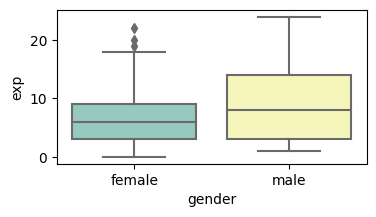

                 sum_sq      df          F        PR(>F)
C(gender)   1274.301429     1.0  41.147951  2.028433e-10
Residual   37038.648487  1196.0        NaN           NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
female   male   2.1354   0.0 1.4823 2.7886   True
-------------------------------------------------


In [93]:
anova_pairwise_tukeyhsd(df_data, 'gender', 'salary')
anova_pairwise_tukeyhsd(df_data, 'gender', 'age')
anova_pairwise_tukeyhsd(df_data, 'gender', 'exp')

C:\Users\PC\AppData\Local\Temp\ipykernel_19556\3905229014.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['edu_num'] = df_data['edu'].replace({


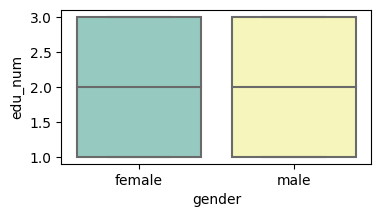

               sum_sq      df         F    PR(>F)
C(gender)    4.078871     1.0  5.172267  0.023127
Residual   943.170711  1196.0       NaN       NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
female   male  -0.1208 0.0231 -0.225 -0.0166   True
---------------------------------------------------


In [94]:
df_data['edu_num'] = df_data['edu'].replace({
    'high school': 0, 
    'bachelor': 1, 
    'master': 2, 
    'phd': 3})
anova_pairwise_tukeyhsd(df_data, 'gender', 'edu_num')